# Vision Transformer for lung colon cancer histopathological images 

**Vision Transformers** are a type of neural network architecture that applies the power of transformers to computer vision tasks. They break down images into smaller patches, process them using self-attention mechanisms, and capture global and local dependencies to understand the image's content and context. Vision Transformers have gained attention for their ability to handle long-range dependencies and have the potential to revolutionize computer vision by challenging the dominance of convolutional neural networks (CNNs).


In [8]:
# create one folder to collect label image folders
!mkdir lung_colon_folder

print("---Copying files under the folder---")
# copy files
!cp -R /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/* lung_colon_folder
!cp -R /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/* lung_colon_folder
print("---Done copying---")

mkdir: cannot create directory ‘lung_colon_folder’: File exists
---Copying files under the folder---
---Done copying---


In [9]:
import datasets

In [10]:
# install
!pip install tensorflow
!pip install transformers datasets tensorboard 
# !brew install git-lfs | 
!pip install git-lfs # to commit big files to hugginface

In [11]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import random

import time
import os

#import datasets
from transformers import ViTFeatureExtractor
from tensorflow import keras
from tensorflow.keras import layers

from glob import glob

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [6]:
from huggingface_hub import notebook_login

notebook_login()

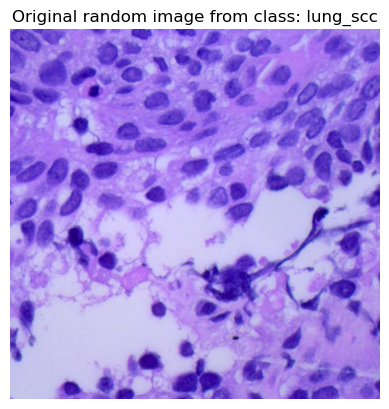

In [12]:
target_class = random.choice(os.listdir("lung_colon_folder/")) # choose a random class
target_dir = "lung_colon_folder/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

In order to train our model we need this folder structure to be Huggingface dataset. We're writing a handful function to create image folder to `Dataset instance`. I'm gonna limit per class image number as 10. Otherwise it's giving memory error. I trained this on my Mac. **If you're gonna use Kaggle or Colab please limit the image number**.

In [13]:

def create_image_folder_dataset(root_path):
    """creates `Dataset` from image folder structure"""

    # get class names by folders names
    _CLASS_NAMES= os.listdir(root_path)
    # defines `datasets` features`
    features=datasets.Features({
                      "img": datasets.Image(),
                      "label": datasets.features.ClassLabel(names=_CLASS_NAMES),
                  })
    # temp list holding datapoints for creation
    img_data_files=[]
    label_data_files=[]
    # load images into list for creation
    for img_class in os.listdir(root_path):
        for img in os.listdir(os.path.join(root_path,img_class))[:600]:
            path_=os.path.join(root_path,img_class,img)
            img_data_files.append(path_)
            label_data_files.append(img_class)
    # create dataset
    ds = datasets.Dataset.from_dict({"img":img_data_files,"label":label_data_files},features=features)
    return ds

In [14]:
cancer_ds = create_image_folder_dataset("lung_colon_folder")

In [15]:
cancer_ds

Dataset({
    features: ['img', 'label'],
    num_rows: 3000
})

Get class names from Dataset instance.

In [16]:
class_labels = cancer_ds.features["label"].names

In [17]:
class_labels


['colon_aca', 'colon_n', 'lung_scc', 'lung_aca', 'lung_n']

This model_name is the model in [Huggingface](https://huggingface.co/google/vit-base-patch16-224-in21k). We're fetching the model and the feature extractor to use this model's blessings. This Vision Transformer (ViT) pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224.

In [18]:
model_name = "google/vit-base-patch16-224-in21k"

In [19]:
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


To facilitate model training, we must transform our 'Images' into pixel values. This task is accomplished using a 🤗 Transformers Feature Extractor, which empowers us to convert the images into a 3D array suitable for inputting into our model. This process will automatically create `pixel_values`.

In [20]:
def process(images):
    images.update(feature_extractor(images["img"], ))
    return images

In [21]:
cancer_ds = cancer_ds.rename_column("label", "labels")

If you think you can't use all 25000 images because of memory issues you can split them. In Kaggle and Google Colab you'll get memory error in the process part. Even if you split it for like 1000 images per class you won't be able to start training due to memory. So you can use 200 images per label. I trained this with whole dataset in M1 Pro Macbook. It took like 5 hours for 5 epoch.

In [22]:
processed_dataset = cancer_ds.map(process, batched=True)
processed_dataset

  0%|          | 0/3 [00:00<?, ?ba/s]

Dataset({
    features: ['img', 'labels', 'pixel_values'],
    num_rows: 3000
})

In [23]:
# test size will be 10% of train dataset
test_size=.10

processed_dataset = processed_dataset.shuffle().train_test_split(test_size=test_size)

## What is Data Collator?
A data collator is an object used in machine learning pipelines, particularly in the context of training deep learning models. Its primary purpose is to take a list of dataset elements and organize them into batches, which can then be efficiently processed during model training.

The role of a data collator is crucial in scenarios where the input data is not uniformly sized or requires additional preprocessing before being fed into the model.

Also Data Collator dynamically pad the inputs received, as well as the labels. We're gonna use that in here.

In [24]:
from huggingface_hub import HfFolder
import tensorflow as tf

id2label = {str(i): label for i, label in enumerate(class_labels)}
label2id = {v: k for k, v in id2label.items()}

num_train_epochs = 5
train_batch_size = 32
eval_batch_size = 32
learning_rate = 3e-5
weight_decay_rate=0.01
num_warmup_steps=0
output_dir=model_name.split("/")[1]
hub_token = HfFolder.get_token() # or your token directly "hf_xxx"
hub_model_id = f'{model_name.split("/")[1]}-lung_and_colon' # this is your model name in huggingface, create first
fp16=False # set to True if you have a GPU

# Train in mixed-precision float16
# Comment this line out if you're using a GPU that will not benefit from this
if fp16:
    tf.keras.mixed_precision.set_global_policy("mixed_float16")

Here we're converting to `tf.Dataset`.



In [25]:
from transformers import DefaultDataCollator

# Data collator that will dynamically pad the inputs received, as well as the labels.
data_collator = DefaultDataCollator(return_tensors="tf")

# converting our train dataset to tf.data.Dataset
tf_train_dataset = processed_dataset["train"].to_tf_dataset(
   columns=['pixel_values'],
   label_cols=["labels"],
   shuffle=True,
   batch_size=train_batch_size,
   collate_fn=data_collator)

# converting our test dataset to tf.data.Dataset
tf_eval_dataset = processed_dataset["test"].to_tf_dataset(
   columns=['pixel_values'],
   label_cols=["labels"],
   shuffle=True,
   batch_size=eval_batch_size,
   collate_fn=data_collator)

Downloading pre-trained model with `TFViTForImageClassification` class.

## What is top-3-accuracy?

Top-3 accuracy is an evaluation metric commonly used in multi-class classification tasks. It measures the percentage of predictions where the correct label appears in the top three predicted classes.

To calculate the top-3 accuracy, the model's predicted probabilities for each class are ranked, and the top three classes with the highest probabilities are considered. If the true label (the ground truth) is among these top three predictions, it is counted as a correct prediction.

Top-3 accuracy is a more forgiving metric than traditional accuracy because it allows for some flexibility in predicting the correct class. It accounts for cases where the model might have made a mistake in assigning the highest probability to the true class but still predicted some of the other relevant classes.

This metric is particularly useful in scenarios where the order of importance or relevance among the predicted classes is not well-defined, or when there are multiple valid correct answers for a given input. By considering the top three predictions, it provides a more lenient evaluation measure that reflects a broader understanding of the model's performance.

In [26]:
from transformers import TFViTForImageClassification, create_optimizer
import tensorflow as tf

# create optimizer wight weigh decay
num_train_steps = len(tf_train_dataset) * num_train_epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=num_warmup_steps,
)

# load pre-trained ViT model
model = TFViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(class_labels),
    id2label=id2label,
    label2id=label2id,
)

# define loss
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# define metrics
metrics=[
    tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
]

# compile model
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics
              )

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTForImageClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
train_results = model.fit(
    tf_train_dataset,
    validation_data=tf_eval_dataset,
    #callbacks=callbacks,
    epochs=num_train_epochs,
)

Epoch 1/5
84/84 [==============================] - 1170s 14s/step - loss: 0.6958 - accuracy: 0.9200 - top-3-accuracy: 0.9829 - val_loss: 0.2895 - val_accuracy: 0.9792 - val_top-3-accuracy: 1.0000
Epoch 2/5
84/84 [==============================] - 1145s 14s/step - loss: 0.2207 - accuracy: 0.9851 - top-3-accuracy: 1.0000 - val_loss: 0.1818 - val_accuracy: 0.9896 - val_top-3-accuracy: 1.0000
Epoch 3/5
84/84 [==============================] - 1144s 14s/step - loss: 0.1483 - accuracy: 0.9944 - top-3-accuracy: 1.0000 - val_loss: 0.1358 - val_accuracy: 0.9931 - val_top-3-accuracy: 1.0000
Epoch 4/5
84/84 [==============================] - 1146s 14s/step - loss: 0.1278 - accuracy: 0.9937 - top-3-accuracy: 1.0000 - val_loss: 0.1224 - val_accuracy: 0.9931 - val_top-3-accuracy: 1.0000
Epoch 5/5
84/84 [==============================] - 1141s 14s/step - loss: 0.1089 - accuracy: 0.9989 - top-3-accuracy: 1.0000 - val_loss: 0.1182 - val_accuracy: 0.9931 - val_top-3-accuracy: 1.0000


In [28]:
#feature_extractor.save_pretrained(output_dir)